In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

from pathlib import Path
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# only run once to unzip the zipped PASCAL VOC datasets:
# !unzip -u "./PASCAL_VOC.zip" -d "."
# os.makedirs("./PASCAL_VOC/VOCtrainval_11-May-2012", exist_ok=True)
# !tar -xf "./VOCtrainval_11-May-2012.tar" -C "./PASCAL_VOC/VOCtrainval_11-May-2012"

In [3]:
base_path = Path("./PASCAL_VOC")

train_2007_path = base_path/"VOCtrainval_06-Nov-2007"
train_2012_path = base_path/"VOCtrainval_11-May-2012"
test_path = base_path/"VOCtest_06-Nov-2007"

train_2007_images_path = train_2007_path/"VOCdevkit/VOC2007/JPEGImages"
train_2012_images_path = train_2012_path/"VOCdevkit/VOC2012/JPEGImages"
test_images_path = test_path/"VOCdevkit/VOC2007/JPEGImages"

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda:0


In [5]:
print("Train 2007 len:", len(os.listdir(train_2007_images_path)))
print("Train 2012 len:", len(os.listdir(train_2012_images_path)))
print("Test 2007 len:", len(os.listdir(test_images_path)))

Train 2007 len: 5011
Train 2012 len: 17125
Test 2007 len: 4952


In [6]:
class Classes():
    def __init__(self):
        self.ctoi = {}
        self.itoc = []

    def __len__(self):
        return len(self.itoc)

    def add_class(self, c):
        self.itoc.append(c)
        self.ctoi[c] = len(self.itoc) - 1

classes = Classes()

for c in ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]: 
    classes.add_class(c)

In [7]:
toy_train_set = datasets.VOCDetection(root=train_2007_path, year='2007', image_set='trainval', download=False)
toy_train_set

Dataset VOCDetection
    Number of datapoints: 5011
    Root location: PASCAL_VOC/VOCtrainval_06-Nov-2007

Item: (<PIL.Image.Image image mode=RGB size=500x333 at 0x7FCF6F4EA0D0>, {'annotation': {'folder': 'VOC2007', 'filename': '004647.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '314796476'}, 'owner': {'flickrid': 'sadisticspice', 'name': 'Spikey Gryphon'}, 'size': {'width': '500', 'height': '333', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'motorbike', 'pose': 'Unspecified', 'truncated': '1', 'difficult': '0', 'bndbox': {'xmin': '83', 'ymin': '121', 'xmax': '298', 'ymax': '332'}}, {'name': 'person', 'pose': 'Frontal', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '275', 'ymin': '57', 'xmax': '371', 'ymax': '312'}, 'part': [{'name': 'head', 'bndbox': {'xmin': '303.121', 'ymin': '55.7097', 'xmax': '333.3629', 'ymax': '90.7903'}}, {'name': 'foot', 'bndbox': {'xmin': '332.9597', 'ymin': '295.629', 'xmax': '363.2016', 'ymax': '310.1452'}}, {'name': 'foot', 'bndbox': {'xmin': '283.3629', 'ymin': '296.8387'

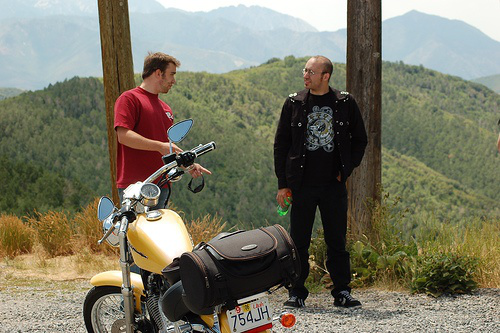

In [8]:
item = toy_train_set[2330]
print("Item:", item)
item[0]

In [9]:
item[1]

{'annotation': {'folder': 'VOC2007',
  'filename': '004647.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '314796476'},
  'owner': {'flickrid': 'sadisticspice', 'name': 'Spikey Gryphon'},
  'size': {'width': '500', 'height': '333', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'motorbike',
    'pose': 'Unspecified',
    'truncated': '1',
    'difficult': '0',
    'bndbox': {'xmin': '83', 'ymin': '121', 'xmax': '298', 'ymax': '332'}},
   {'name': 'person',
    'pose': 'Frontal',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '275', 'ymin': '57', 'xmax': '371', 'ymax': '312'},
    'part': [{'name': 'head',
      'bndbox': {'xmin': '303.121',
       'ymin': '55.7097',
       'xmax': '333.3629',
       'ymax': '90.7903'}},
     {'name': 'foot',
      'bndbox': {'xmin': '332.9597',
       'ymin': '295.629',
       'xmax': '363.2016',
       'ymax': '310.1452'}},
     {'name': 'foot

In [10]:
def YOLOTargetFromVOCAnnotation(annotation):
    """
        Tranforms a VOC-formatted annotation into a YOLO-formatted target
        annotation: a dict of properties in PASCAL VOC dataset format
        classes: Classes object
        Returns a YOLO-formatted tensor of shape (7,7,30) where 7 = grid length and 30 = 5 x BB + C
    """
    grid_len = 7 
    cell_size = 1/grid_len
    target = torch.zeros((grid_len,grid_len,30))
    annotation = annotation['annotation']
    img_wh = torch.tensor([float(annotation['size']['width']), float(annotation['size']['height'])])
    objs = annotation['object']
    if isinstance(objs, dict): objs = [objs] # sometimes 'object' is a list, sometimes only a single item
    for obj in objs:
        bbox = obj['bndbox']
        label = classes.ctoi[obj['name']]
        x1y1 = torch.tensor([float(bbox['xmin']), float(bbox['ymin'])]) / img_wh
        x2y2 = torch.tensor([float(bbox['xmax']), float(bbox['ymax'])]) / img_wh
        xcyc = (x2y2 + x1y1) / 2
        wh = x2y2 - x1y1
        ji = torch.floor(xcyc / cell_size).to(torch.long)
        xcyc_rel = (xcyc - (ji * cell_size)) / cell_size
        for bbox_num in range(2):
            offset = bbox_num * 5
            target[ji[1], ji[0], offset:offset+2] = xcyc_rel # cell i,j, bb 1, x and y offset
            target[ji[1], ji[0], offset+2:offset+4] = wh # cell i,j, bb1, width and height
            target[ji[1], ji[0], offset+4] = 1 # cell i,j, bb 1, confidence
        target[ji[1], ji[0], 10 + label] = 1 # cell i,j, class probability
    return target

In [11]:
target = YOLOTargetFromVOCAnnotation(item[1])
print("Shape", target.shape)
target

Shape torch.Size([7, 7, 30])


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2960, 0.7958, 0.1960,  ..., 0.0000, 0.0000, 0.

motorbike with width 215.0 and height 211.0
person with width 96.0 and height 255.0
person with width 98.0 and height 160.0


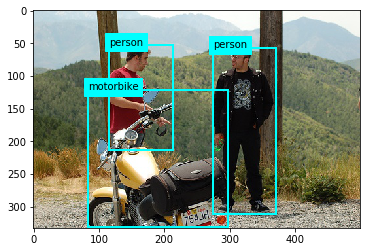

In [12]:
import matplotlib.pyplot as plt
from matplotlib import patches

def show_boxes_voc(image_path, target):
    """
        image_path: path to image
        target: the (7,7,30) tensor of bounding box targets
    """
    plt.imshow(plt.imread(image_path))
    ax = plt.gca()
    for obj in target['annotation']['object']:
        x = float(obj['bndbox']['xmin'])
        y = float(obj['bndbox']['ymin'])
        w = float(obj['bndbox']['xmax']) - x
        h = float(obj['bndbox']['ymax']) - y
        label = obj['name']
        print(f"{label} with width {w} and height {h}")
        rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='cyan',fill = False)
        ax.add_patch(rect)
        plt.text(x, y, label, backgroundcolor="cyan")
    plt.show()

show_boxes_voc(train_2007_images_path/item[1]['annotation']['filename'], item[1])

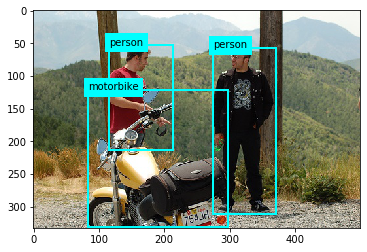

In [13]:
import matplotlib.pyplot as plt
from matplotlib import patches

def show_boxes_yolo(image_path, width, height, target, classes, threshold=0.5):
    """
        image_path: path to image
        target: the (7,7,30) tensor of bounding box targets
    """
    if target.shape == (1,7*7*30):
        target = target.view((7,7,30))
    bbox_per_cell = 2
    grid_size = 7
    plt.imshow(plt.imread(image_path))
    ax = plt.gca()
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            label = classes.itoc[torch.argmax(target[i, j, 10:] - 10)]
            for bbox in range(2):
                offset = bbox * 5
                if target[i, j, offset + 4] > threshold:
                    w = target[i, j, offset + 2] * width
                    h = target[i, j, offset + 3] * height
                    cell_w = width / grid_size
                    cell_h = height / grid_size
                    x = (j + target[i, j, offset + 0]) * cell_w - (w / 2)
                    y = (i + target[i, j, offset + 1]) * cell_h - (h / 2)
                    rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='cyan',fill = False)
                    ax.add_patch(rect)
                    plt.text(x, y, label, backgroundcolor="cyan")
    plt.show()

show_boxes_yolo(train_2007_images_path/item[1]['annotation']['filename'], 
           float(item[1]['annotation']['size']['width']),
           float(item[1]['annotation']['size']['height']),
           YOLOTargetFromVOCAnnotation(item[1]),
           classes)

In [14]:
class YOLOTargetTransform(object):
    def __call__(self, sample):
        return YOLOTargetFromVOCAnnotation(sample)

In [15]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1), # uncomment this to do augmentation if overfitting
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # hardcoded values the network i'll be using was pretrained with
])

train_2007_ds = datasets.VOCDetection(
    root=train_2007_path, 
    year='2007', 
    image_set='trainval', 
    download=False, 
    transform=train_tfms, 
    target_transform=YOLOTargetTransform())
train_2007_ds

Dataset VOCDetection
    Number of datapoints: 5011
    Root location: PASCAL_VOC/VOCtrainval_06-Nov-2007
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.1, 0.1])
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Target transform: <__main__.YOLOTargetTransform object at 0x7fcf6512ca90>

In [16]:
train_2012_ds = datasets.VOCDetection(
    root=train_2012_path, 
    year='2012', 
    image_set='trainval', 
    download=False, 
    transform=train_tfms, 
    target_transform=YOLOTargetTransform())
train_2012_ds

Dataset VOCDetection
    Number of datapoints: 11540
    Root location: PASCAL_VOC/VOCtrainval_11-May-2012
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.1, 0.1])
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Target transform: <__main__.YOLOTargetTransform object at 0x7fcf6512c3d0>

In [17]:
train_ds = ConcatDataset([train_2007_ds, train_2012_ds])
len(train_ds)

16551

In [18]:
test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
])

test_ds = datasets.VOCDetection(
    root=test_path, 
    year='2007', 
    image_set='test', 
    download=False, 
    transform=test_tfms, 
    target_transform=YOLOTargetTransform())
test_ds

Dataset VOCDetection
    Number of datapoints: 4952
    Root location: PASCAL_VOC/VOCtest_06-Nov-2007
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Target transform: <__main__.YOLOTargetTransform object at 0x7fcf65176a50>

In [19]:
valid_len = 512
# test_ds, valid_ds = random_split(test_ds, [len(test_ds) - valid_len, valid_len], generator=torch.Generator().manual_seed(42))
test_ds, valid_ds = random_split(test_ds, [len(test_ds) - valid_len, valid_len])
print("Test ds len:", len(test_ds))
print("Valid ds len:", len(valid_ds))

Test ds len: 4440
Valid ds len: 512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


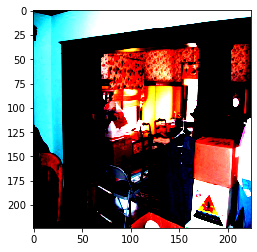

In [20]:
item = train_2007_ds[0]
plt.imshow(item[0].permute(1,2,0))
# looks weird because of the normalization

In [21]:
train_dl = DataLoader(dataset=train_ds, batch_size=64, shuffle=True, num_workers=16)
valid_dl = DataLoader(dataset=valid_ds, batch_size=64, shuffle=False, num_workers=16)
test_dl = DataLoader(dataset=test_ds, batch_size=64, shuffle=False, num_workers=16)
print("Train dl batch count:", len(train_dl))
print("Valid dl batch count:", len(valid_dl))
print("Test dl batch count:", len(test_dl))

Train dl batch count: 259
Valid dl batch count: 8
Test dl batch count: 70


In [22]:
def forward_pass(batch_X, batch_y, model, optimizer, criterion, train = False): 
    if train:
        model.zero_grad()
    preds = model(batch_X)
    loss = criterion(preds, batch_y)
    if train:
        loss.backward()
        optimizer.step()
    return loss, preds

In [23]:
from tqdm.notebook import tqdm

def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss = 0
        model.train()
        for _, (batch_X, batch_y) in tqdm(enumerate(train_dl)):
            batch_X = batch_X.to(device)
            batch_y = batch_y.view(-1, 7*7*30).to(device)
            loss, _ = forward_pass(batch_X, batch_y, model, optimizer, criterion, train=True)
            train_loss += loss.item()
        train_loss /= len(train_dl)

        model.eval()
        valid_loss = 0
        for batch_X, batch_y in valid_dl:
            batch_X = batch_X.to(device)
            batch_y = batch_y.view(-1, 7*7*30).to(device)
            with torch.no_grad():
                loss, _ = forward_pass(batch_X, batch_y, model, optimizer, criterion, train=False)
            valid_loss += loss.item()
        valid_loss /= len(valid_dl)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'Epoch {epoch + 1} complete. Train loss: {round(train_loss, 3)}. Valid loss: {round(valid_loss, 3)}')
    
    return train_losses, valid_losses

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class StolenLoss(nn.Module):

    def __init__(self, feature_size=7, num_bboxes=2, num_classes=20, lambda_coord=5.0, lambda_noobj=0.5):
        """ Constructor.
        Args:
            feature_size: (int) size of input feature map.
            num_bboxes: (int) number of bboxes per each cell.
            num_classes: (int) number of the object classes.
            lambda_coord: (float) weight for bbox location/size losses.
            lambda_noobj: (float) weight for no-objectness loss.
        """
        super(StolenLoss, self).__init__()

        self.S = feature_size
        self.B = num_bboxes
        self.C = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj


    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

    def forward(self, pred_tensor, target_tensor):
        new_shape = (-1, 7, 7, 30) # (batches, 7, 7, 30)
        pred_tensor, target_tensor = pred_tensor.view(new_shape), target_tensor.view(new_shape)
        """ Compute loss for YOLO training.
        Args:
            pred_tensor: (Tensor) predictions, sized [n_batch, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor: (Tensor) targets, sized [n_batch, S, S, Bx5+C].
        Returns:
            (Tensor): loss, sized [1, ].
        """
        # TODO: Romove redundant dimensions for some Tensors.

        S, B, C = self.S, self.B, self.C
        N = 5 * B + C    # 5=len([x, y, w, h, conf]

        batch_size = pred_tensor.size(0)
        coord_mask = target_tensor[:, :, :, 4] > 0  # mask for the cells which contain objects. [n_batch, S, S]
        noobj_mask = target_tensor[:, :, :, 4] == 0 # mask for the cells which do not contain objects. [n_batch, S, S]
        coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]

        coord_pred = pred_tensor[coord_mask].view(-1, N)            # pred tensor on the cells which contain objects. [n_coord, N]
                                                                    # n_coord: number of the cells which contain objects.
        bbox_pred = coord_pred[:, :5*B].contiguous().view(-1, 5)    # [n_coord x B, 5=len([x, y, w, h, conf])]
        class_pred = coord_pred[:, 5*B:]                            # [n_coord, C]

        coord_target = target_tensor[coord_mask].view(-1, N)        # target tensor on the cells which contain objects. [n_coord, N]
                                                                    # n_coord: number of the cells which contain objects.
        bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)# [n_coord x B, 5=len([x, y, w, h, conf])]
        class_target = coord_target[:, 5*B:]                        # [n_coord, C]

        # Compute loss for the cells with no object bbox.
        noobj_pred = pred_tensor[noobj_mask].view(-1, N)        # pred tensor on the cells which do not contain objects. [n_noobj, N]
                                                                # n_noobj: number of the cells which do not contain objects.
        noobj_target = target_tensor[noobj_mask].view(-1, N)    # target tensor on the cells which do not contain objects. [n_noobj, N]
                                                                # n_noobj: number of the cells which do not contain objects.
        noobj_conf_mask = torch.cuda.ByteTensor(noobj_pred.size()).fill_(0) # [n_noobj, N]
        for b in range(B):
            noobj_conf_mask[:, 4 + b*5] = 1 # noobj_conf_mask[:, 4] = 1; noobj_conf_mask[:, 9] = 1
        noobj_pred_conf = noobj_pred[noobj_conf_mask]       # [n_noobj, 2=len([conf1, conf2])]
        noobj_target_conf = noobj_target[noobj_conf_mask]   # [n_noobj, 2=len([conf1, conf2])]
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum')

        # Compute loss for the cells with objects.
        coord_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(0)    # [n_coord x B, 5]
        coord_not_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(1)# [n_coord x B, 5]
        bbox_target_iou = torch.zeros(bbox_target.size()).cuda()                    # [n_coord x B, 5], only the last 1=(conf,) is used

        # Choose the predicted bbox having the highest IoU for each target bbox.
        for i in range(0, bbox_target.size(0), B):
            pred = bbox_pred[i:i+B] # predicted bboxes at i-th cell, [B, 5=len([x, y, w, h, conf])]
            pred_xyxy = Variable(torch.FloatTensor(pred.size())) # [B, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=pred[:, 2] and (w,h)=pred[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            pred_xyxy[:,  :2] = pred[:, :2]/float(S) - 0.5 * pred[:, 2:4]
            pred_xyxy[:, 2:4] = pred[:, :2]/float(S) + 0.5 * pred[:, 2:4]

            target = bbox_target[i] # target bbox at i-th cell. Because target boxes contained by each cell are identical in current implementation, enough to extract the first one.
            target = bbox_target[i].view(-1, 5) # target bbox at i-th cell, [1, 5=len([x, y, w, h, conf])]
            target_xyxy = Variable(torch.FloatTensor(target.size())) # [1, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=target[:, 2] and (w,h)=target[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            target_xyxy[:,  :2] = target[:, :2]/float(S) - 0.5 * target[:, 2:4]
            target_xyxy[:, 2:4] = target[:, :2]/float(S) + 0.5 * target[:, 2:4]

            iou = self.compute_iou(pred_xyxy[:, :4], target_xyxy[:, :4]) # [B, 1]
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()

            coord_response_mask[i+max_index] = 1
            coord_not_response_mask[i+max_index] = 0

            # "we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth"
            # from the original paper of YOLO.
            bbox_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        bbox_target_iou = Variable(bbox_target_iou).cuda()

        # BBox location/size and objectness loss for the response bboxes.
        bbox_pred_response = bbox_pred[coord_response_mask].view(-1, 5)      # [n_response, 5]
        bbox_target_response = bbox_target[coord_response_mask].view(-1, 5)  # [n_response, 5], only the first 4=(x, y, w, h) are used
        target_iou = bbox_target_iou[coord_response_mask].view(-1, 5)        # [n_response, 5], only the last 1=(conf,) is used
        loss_xy = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')
        loss_wh = F.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4]), torch.sqrt(bbox_target_response[:, 2:4]), reduction='sum')
        loss_obj = F.mse_loss(bbox_pred_response[:, 4], target_iou[:, 4], reduction='sum')

        # Class probability loss for the cells which contain objects.
        loss_class = F.mse_loss(class_pred, class_target, reduction='sum')

        # print("Centers loss:", loss_xy.item())
        # print("Size loss:", loss_wh.item())
        # print("Conf obj loss:", loss_obj.item())
        # print("Conf noobj loss:", loss_noobj.item())
        # print("Class loss:", loss_class.item())

        # Total loss
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj + loss_class
        loss = loss / float(batch_size)

        return loss

In [25]:
class YOLOLoss(nn.Module):
    def __init__(self, l_coord=5, l_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.l_coord = l_coord
        self.l_noobj = l_noobj

    def forward(self, preds, targets):
        new_shape = (-1, 7, 7, 30) # (batches, 7, 7, 30)
        preds, targets = preds.view(new_shape), targets.view(new_shape)

        batch_size = preds.shape[0]
        obj_mask = targets[:,:,:,4] == 1 # (batches, 7, 7)
        noobj_mask = obj_mask == False # (batches, 7, 7)
        obj_box_preds = preds[obj_mask][:, :10] # (objects, 10)
        obj_box_targets = targets[obj_mask][:, :10] # (objects, 10)

        centers_loss = 0.
        size_loss = 0.
        confidence_loss_obj = 0.
        confidence_loss_noobj = 0.

        for obj in range(obj_box_preds.shape[0]):
            max_iou = float('-inf')
            max_iou_box_idx = 0
            for b in range(2):
                offset = b * 5
                iou = self.__iou(obj_box_preds[obj, offset: offset+4], obj_box_targets[obj, :4])
                if iou > max_iou:
                    max_iou = iou
                    max_iou_box_idx = b
            offset = max_iou_box_idx * 5
            pred = obj_box_preds[obj, offset: offset+5]
            target = obj_box_targets[obj, :5]
            centers_loss += F.mse_loss(pred[:2], target[:2], reduction='sum')
            size_loss += F.mse_loss(torch.sqrt(pred[2:4]), torch.sqrt(target[2:4]), reduction='sum')
            confidence_loss_obj += F.mse_loss(pred[4], target[4], reduction='sum')
            # take the other bbox in that cell and count it towards noobj conf loss
            offset = 5 - offset
            confidence_loss_noobj += F.mse_loss(obj_box_preds[obj, offset+4], target[4], reduction='sum')

        noobj_box_preds = preds[noobj_mask][:, :10] # (noobjects, 10)
        noobj_box_targets = targets[noobj_mask][:, :10]
        for b in range(2):
            offset = b * 5
            confidence_loss_noobj += F.mse_loss(noobj_box_preds[:, offset+4], noobj_box_targets[:, 4], reduction='sum')

        obj_class_preds = preds[obj_mask][:, 10:]
        obj_class_targets = targets[obj_mask][:, 10:]
        class_loss = F.mse_loss(obj_class_preds, obj_class_targets, reduction='sum')

        # print("Centers loss:", centers_loss.item())
        # print("Size loss:", size_loss.item())
        # print("Conf obj loss:", confidence_loss_obj.item())
        # print("Conf noobj loss:", confidence_loss_noobj.item())
        # print("Class loss:", class_loss.item())

        return (self.l_coord * (centers_loss + size_loss) + confidence_loss_obj + self.l_noobj * confidence_loss_noobj + class_loss) / batch_size

    def __iou(self, bbox1, bbox2):
        """ 
        Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x, y, w, h].
        """
        bbox1 = self.__get_coords(bbox1).unsqueeze(0)
        bbox2 = self.__get_coords(bbox2).unsqueeze(0)

        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

    def __get_coords(self, bbox):
        """
        Receives [x, y, w, h]
        Returns [x1, y1, x2, y2]
        """
        res = torch.zeros(4)
        x = bbox[0]
        y = bbox[1]
        w = bbox[2] * 7
        h = bbox[3] * 7
        res[0] = x - (w / 2)
        res[1] = y - (h / 2)
        res[2] = x + (w / 2)
        res[3] = y + (h / 2)
        return res

In [26]:
loss = StolenLoss() # change to YOLOLoss when implemented :)

In [43]:
model = models.vgg11_bn(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(in_features=8192, out_features=4096, bias=True),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.7),
    nn.Linear(in_features=4096, out_features=7*7*30, bias=True),
    nn.Sigmoid()
)
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(4,4))

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [44]:
output = model(train_ds[0][0].unsqueeze(0).to(device))
output.shape

torch.Size([1, 1470])

In [45]:
yoloLoss = YOLOLoss()
print("Yolo:", yoloLoss(model(train_ds[0][0].unsqueeze(0).to(device)), train_ds[0][1].unsqueeze(0).to(device)).item())
stolenLoss = StolenLoss()
print("Stolen:", stolenLoss(model(train_ds[0][0].unsqueeze(0).to(device)), train_ds[0][1].unsqueeze(0).to(device)).item())

print()
batch_X, batch_y = next(iter(train_dl))
batch_X = batch_X.to(device)
batch_y = batch_y.view(-1, 7*7*30).to(device)
print("Time taken by my YOLOLoss to compute loss for one batch:")
%timeit yoloLoss(model(batch_X), batch_y)
print("Time taken by the stolen loss to compute loss for one batch:")
%timeit stolenLoss(model(batch_X), batch_y)

Yolo: 48.44623947143555
Stolen: 47.79330062866211

Time taken by my YOLOLoss to compute loss for one batch:
350 ms ± 6.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time taken by the stolen loss to compute loss for one batch:
206 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=1e-3, momentum=0.9, weight_decay=5e-4)

lrs = [
    (10, 1e-3),
    (20, 1e-2),
    (20, 1e-2),
    (10, 1e-3),
    (5, 1e-4)
]

train_losses_hist = []
valid_losses_hist = []

for epochs, lr in lrs:
    print(f"Training for {epochs} epochs with lr={lr}")
    for group in optimizer.param_groups: 
        group['lr'] = lr
    train_losses, valid_losses = train(model, optimizer, loss, train_dl, valid_dl, epochs)
    train_losses_hist.extend(train_losses)
    valid_losses_hist.extend(valid_losses)

Training for 10 epochs with lr=0.001



Epoch 1 complete. Train loss: 8.278. Valid loss: 5.873



Epoch 2 complete. Train loss: 5.635. Valid loss: 5.684



Epoch 3 complete. Train loss: 5.435. Valid loss: 5.507



Epoch 4 complete. Train loss: 5.257. Valid loss: 5.426



Epoch 5 complete. Train loss: 5.123. Valid loss: 5.332



Epoch 6 complete. Train loss: 5.009. Valid loss: 5.257



Epoch 7 complete. Train loss: 4.917. Valid loss: 5.202



Epoch 8 complete. Train loss: 4.834. Valid loss: 5.109



Epoch 9 complete. Train loss: 4.772. Valid loss: 5.073



Epoch 10 complete. Train loss: 4.706. Valid loss: 4.983
Training for 20 epochs with lr=0.01



Epoch 1 complete. Train loss: 5.152. Valid loss: 5.273



Epoch 2 complete. Train loss: 5.047. Valid loss: 4.967



Epoch 3 complete. Train loss: 4.905. Valid loss: 4.965



Epoch 4 complete. Train loss: 4.798. Valid loss: 4.984



Epoch 5 complete. Train loss: 4.709. Valid loss: 4.931



Epoch 6 complete. Train loss: 4.601. Valid loss: 5.06



Epoch 7 complete. Train loss: 4.569. Valid loss: 4.9



Epoch 8 complete. Train loss: 4.49. Valid loss: 4.902



Epoch 9 complete. Train loss: 4.469. Valid loss: 5.032



Epoch 10 complete. Train loss: 4.421. Valid loss: 5.061



Epoch 11 complete. Train loss: 4.385. Valid loss: 5.124



Epoch 12 complete. Train loss: 4.371. Valid loss: 5.276



Epoch 13 complete. Train loss: 4.362. Valid loss: 5.161



Epoch 14 complete. Train loss: 4.325. Valid loss: 5.147



Epoch 15 complete. Train loss: 4.296. Valid loss: 5.375



Epoch 16 complete. Train loss: 4.281. Valid loss: 5.242



Epoch 17 complete. Train loss: 4.259. Valid loss: 5.211



Epoch 18 complete. Train loss: 4.229. Valid loss: 5.584



Epoch 19 complete. Train loss: 4.23. Valid loss: 5.331



Epoch 20 complete. Train loss: 4.216. Valid loss: 5.314
Training for 20 epochs with lr=0.01



Epoch 1 complete. Train loss: 4.206. Valid loss: 5.549



Epoch 2 complete. Train loss: 4.168. Valid loss: 5.573



Epoch 3 complete. Train loss: 4.13. Valid loss: 5.518



Epoch 4 complete. Train loss: 4.13. Valid loss: 5.514



Epoch 5 complete. Train loss: 4.111. Valid loss: 5.76



Epoch 6 complete. Train loss: 4.098. Valid loss: 5.598



Epoch 7 complete. Train loss: 4.076. Valid loss: 5.358



Epoch 8 complete. Train loss: 4.029. Valid loss: 5.628



Epoch 9 complete. Train loss: 4.038. Valid loss: 5.562



Epoch 10 complete. Train loss: 4.006. Valid loss: 5.502



Epoch 11 complete. Train loss: 3.963. Valid loss: 5.51



Epoch 12 complete. Train loss: 3.964. Valid loss: 5.49



Epoch 13 complete. Train loss: 3.921. Valid loss: 5.341



Epoch 14 complete. Train loss: 3.91. Valid loss: 5.289



Epoch 15 complete. Train loss: 3.882. Valid loss: 5.211



Epoch 16 complete. Train loss: 3.876. Valid loss: 5.106



Epoch 18 complete. Train loss: 3.809. Valid loss: 5.173



Epoch 19 complete. Train loss: 3.779. Valid loss: 5.119



Epoch 20 complete. Train loss: 3.738. Valid loss: 5.12
Training for 10 epochs with lr=0.001



Epoch 1 complete. Train loss: 3.568. Valid loss: 5.025



Epoch 2 complete. Train loss: 3.476. Valid loss: 4.961



Epoch 3 complete. Train loss: 3.423. Valid loss: 5.029



Epoch 4 complete. Train loss: 3.382. Valid loss: 4.94



Epoch 5 complete. Train loss: 3.34. Valid loss: 4.945



Epoch 6 complete. Train loss: 3.327. Valid loss: 4.892



Epoch 7 complete. Train loss: 3.304. Valid loss: 4.853



Epoch 8 complete. Train loss: 3.275. Valid loss: 4.85


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



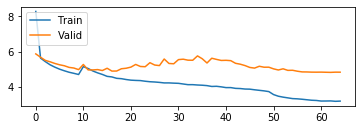

In [47]:
fig = plt.figure()
ax1 = plt.subplot2grid((2, 1), (0, 0))
ax1.plot(train_losses_hist, label = 'Train')
ax1.plot(valid_losses_hist, label = 'Valid')
ax1.legend(loc = 2)
plt.show()

In [ ]:
model.eval()

for idx in range(20):
    item = train_set[idx]
    transformed_item = train_ds[idx]
    preds = model(transformed_item[0].unsqueeze(0).to(device))
    show_boxes_yolo(train_path/"VOCdevkit/VOC2007/JPEGImages"/item[1]['annotation']['filename'], 
            float(item[1]['annotation']['size']['width']),
            float(item[1]['annotation']['size']['height']),
            preds, classes, threshold=0.3)

In [ ]:
for idx in range(20):
    item = test_set[idx]
    transformed_item = test_ds[idx]
    preds = model(transformed_item[0].unsqueeze(0).to(device))
    show_boxes_yolo(test_path/"VOCdevkit/VOC2007/JPEGImages"/item[1]['annotation']['filename'], 
            float(item[1]['annotation']['size']['width']),
            float(item[1]['annotation']['size']['height']),
            preds, classes, threshold=0.3)

In [ ]:
"""
    TODO:
    - Plot loss over epochs to check overfitting
    - Get some kind of metric a human can understand
"""

In [ ]:
def reformat_bboxes(outputs):
    """
        Convert [x,y,w,h,c,x,y,w,h,c,c1,c2,c3,c4...c20] into [l,t,r,b,l,t,r,b,cl,co]
        Input is of shape [-1, 7, 7, 30]
    """


def generate_labels():
    """
        Need to generate labels in format [class] [conf] [left] [top] [right] [bottom] for both targets and preds
        To feed them to https://github.com/rafaelpadilla/Object-Detection-Metrics#optional-arguments
        Not in the mood to code out my own mAP, what it calculates is very straightforward though
    """
    model.eval()
    dir = "/content/drive/My Drive/data/yolo_detections"
    preds_dir = dir/"predictions"
    truths_dir = dir/"groundtruths"
    os.makedirs(preds_dir, exist_ok=True)
    os.makedirs(truths_dir, exist_ok=True)
    count = 0
    for batch_X, targets in test_dl:
        batch_X, batch_Y = batch_X.to(device), targets.view(-1, 7*7*30).to(device)
        preds = model(batch_X)
        preds = preds.view(-1, 7, 7, 30).cpu()
        preds, targets = reformat_bboxes(preds), reformat_bboxes(targets)
        for img in range(preds.shape[0]):
            with open(preds_dir/(str(count)+".txt"), "w") as f_pred:
                with open(truths_dir/(str(count)+".txt"), "w") as f_truth:
                    for row in range(preds.shape[1]):
                        for cell in range(preds.shape[2]):
                            for bbox in range(2):
                                offset = bbox*5
                                f_pred.write()
            count += 1

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/data/vgg16.pth")

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/data/vgg16.pth"))